### Retrieving the core flow from geomagnetic measures using _physics-informed neural networks_ (PiNNs)

In [1]:
%pip install pygeodyntools --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy
import pygeotools
import matplotlib.pyplot as plt
import tqdm
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import math
import torch.nn.functional as F

In [3]:
# Setting the seed for same result every time
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

### 0) Useful parameters

In [ ]:
time_of_study: int = 2020       # Time of the study

number_of_inputs: int = 2       # Number of input variables (θ and φ angles)
number_of_outputs: int = 3      # Number of output variables (uθ, uφ, br)

number_of_layers: int = 5      # Number of layers
number_of_neurons: int = 32     # Number of neurons

number_epochs: int = 10000      # Number of epochs

fine_tune: bool = True         # Fine-tuning the model using L-BFGS?
number_steps: int = 500         # Number of steps for the fine tuning

grid_size: int = 3              # Using 3deg per 3deg grid

#patch: tuple = (95, 175, 275, 355) 
patch: tuple = (0, 180, 0, 360)   # Defining the patch

use_synthetic_sv: bool = False   # Do we use a synthetic SV?

estimate_small_scale_br: bool = False # Do we estimate the small-scales of Br?

filter_br: bool = True         # Do we filter Br?
σ_filter_br: float = 0.01

λ_dbrdt = 1
λ_br = 1
λ_tg = 1e4
λ_tor = 0
λ_wn = 1e-4
λ_sn = 0
λ_ff = 0

losses: dict = {                # The different losses to use (available: misfit_dbrdt, misfit_br, tangential_geostrophy, weak_norm, strong_norm, vorticity)
    "misfit_dbrdt": λ_dbrdt,
    "misfit_br": λ_br,
    "tangential_geostrophy": λ_tg,
    "weak_norm": λ_wn,
    # "strong_norm": λ_sn
}


lmax_spec: int = 13          # spherical harmonic truncation for spectrum
λ_spec_br = 1e-2       # weight of spectral Br loss

losses.update({
    "spectral_br": λ_spec_br
})


### 1) Retrieving the data from geodynamo simulations

In [ ]:
# Initializing the library
pygeo = pygeotools.pygeotools()

# Defining the path and the name of the model
model_path = "geodynamo.hdf5"
model_name = "model_geodynamo"

# Loading the model
pygeo.loadModel(model_name, "pygeodyn_hdf5", model_path)

# Defining the grid for computing the fields
# It is 3°x3° angular grid
if not pygeo.isGrid(f"{grid_size}deg"):
    pygeo.addGrid(f"{grid_size}deg", grid_size, grid_size)

# Setting the grid
pygeo.setGrid(f"{grid_size}deg")

# Retrieving the angles
_, (thetas, phis) = pygeo.getCurrentGrid()

# Defining the context for computing the SV and MF, and U
context_mf = {"lmax": 13, "r": pygeo.constants["rCore"]}
context_sv = {"lmax": 13, "r": pygeo.constants["rCore"]}
context_u = {"lmax": 18, "r": pygeo.constants["rCore"]}

# Computing the fields
SV = pygeo.addMeasure(model_name, "SV", context_sv)
MF = pygeo.addMeasure(model_name, "MF", context_mf)
U = pygeo.addMeasure(model_name, "U", context_u)

# Retrieving the times
times = pygeo.getQuantity(model_name, "times")

# Retrieving the associated times index
idx_times = numpy.argmin(numpy.abs(times - time_of_study))

# Retrieving the components of the fields
dbrdt_obs = SV[idx_times, ..., 0]
br_obs = MF[idx_times, ..., 0]
dbrdth_obs = numpy.gradient(br_obs, thetas, axis=0)
dbrdph_obs = numpy.gradient(br_obs, phis, axis=1)
uθ_obs = U[idx_times, ..., 1]
uφ_obs = U[idx_times, ..., 2]

# Storing into the observations dict
observations = {
    "dbrdt": dbrdt_obs, "br": br_obs, "uth": uθ_obs, "uph": uφ_obs, "dbrdth": dbrdth_obs, "dbrdph": dbrdph_obs
}

pygeotools was initialized with `verbose=True`.
15


### 1 bis) Generating synthetic SV

In [6]:
r = 3480.

In [7]:
if use_synthetic_sv:

    # Creating synthetic data
    θ = thetas
    φ = phis

    θ_grid, φ_grid = numpy.meshgrid(θ, φ, indexing="ij")

    sinθ = numpy.sin(θ_grid).clip(1e-2, 1)
    cosθ = numpy.cos(θ_grid)

    dθ = numpy.gradient(θ).mean()
    dφ = numpy.gradient(φ).mean()

    dΩ = sinθ * dθ * dφ

    duθdθ = numpy.gradient(uθ_obs, θ, axis=0)
    duθdφ = numpy.gradient(uθ_obs, φ, axis=1)
    duφdθ = numpy.gradient(uφ_obs, θ, axis=0)
    duφdφ = numpy.gradient(uφ_obs, φ, axis=1)

    divh_uh= (1 / (r * sinθ)) * (duθdθ * sinθ + uθ_obs * cosθ + duφdφ)

    dbrdth = numpy.gradient(br_obs, θ, axis=0)
    dbrdph = numpy.gradient(br_obs, φ, axis=1)

    observations["dbrdth"] = dbrdth
    observations["dbrdph"] = dbrdph

    gradθbr = dbrdth / r
    gradφbr = dbrdph / (r * sinθ)

    br_divh_uh = br_obs * divh_uh
    uh_dot_gradbr = uθ_obs * gradθbr + uφ_obs * gradφbr

    dbrdt = -(br_divh_uh + uh_dot_gradbr)

    # Overwriting the dbrdt observation
    observations["dbrdt"] = dbrdt

### 2) Defining the network architecture

In [8]:
class Network(torch.nn.Module):

    def __init__(self, nb_input: int, nb_output: int, nb_layer: int, nb_neuron: int) -> None:
        
        # Initializing the torch module
        super(Network, self).__init__()

        # Initializing the layers
        layers = []

        # Creating the first layer
        layers.append(torch.nn.Linear(nb_input, nb_neuron))
        layers.append(torch.nn.Tanh())

        # Creating the hidden layers
        for _ in range(nb_layer):
            layers.append(torch.nn.Linear(nb_neuron, nb_neuron))
            layers.append(torch.nn.Tanh())

        # Creating the last layer
        layers.append(torch.nn.Linear(nb_neuron, nb_output))

        # Creating the network
        self.net: torch.nn.Sequential = torch.nn.Sequential(*layers)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.net(inputs)

In [9]:
# Defining the network instance
network_instance = Network(number_of_inputs, number_of_outputs, number_of_layers, number_of_neurons)

### 3) Creating the tensors

In [10]:
# Function to create a tensor from a numpy array
def as_tensor(numpy_array: numpy.ndarray, requires_grad: bool = False) -> torch.Tensor:
    return torch.tensor(numpy_array, dtype=torch.float32, requires_grad=requires_grad)

# Function to create an autograd tensor from a tensor
def as_grad(tensor: torch.Tensor, input: torch.Tensor) -> torch.Tensor:
    return torch.autograd.grad(tensor, input, torch.ones_like(tensor), retain_graph=True, create_graph=True)[0]

In [11]:
# Converting back the angles in degrees
thetas_deg: numpy.ndarray = numpy.round(numpy.rad2deg(thetas), 3)
phis_deg: numpy.ndarray = numpy.round(numpy.rad2deg(phis), 3)

# finding index close to distance of target to patch and then using those index to slice
idx_theta_min = numpy.argmin(numpy.abs(thetas_deg - patch[0]))
idx_theta_max = numpy.argmin(numpy.abs(thetas_deg - patch[1]))
idx_phi_min = numpy.argmin(numpy.abs(phis_deg - patch[2]))
idx_phi_max = numpy.argmin(numpy.abs(phis_deg - patch[3]))

# Avoiding conflict with the slice end.... not to go out of bound
idx_theta_max = None if idx_theta_max + 1 == len(thetas_deg) else idx_theta_max + 1 
idx_phi_max = None if idx_phi_max + 1 == len(phis_deg) else idx_phi_max + 1

# Defining the slices (to ease the notation afterwards)
slice_thetas = slice(idx_theta_min, idx_theta_max, 1)
slice_phis = slice(idx_phi_min, idx_phi_max, 1)

# Creating the new grid
thetas_grid, phis_grid = numpy.meshgrid(thetas, phis, indexing="ij")

# Defining the tensors from the observations

tensors = {} # here i will keep alll transformed tensors of observations









# Looping over all observations (real data stored in dictionary).
# in dict, key is like name and val is like Fariha. to call name we can specify like dict[name] and in return we get Fariha
# Finally, we converted it to PyTorch tensors and stored them in the tensors dictionary under the same keys ("br", "dbrdt").
 
for name in observations:
    field = observations[name][slice_thetas, slice_phis].reshape(-1, 1) # (sliced reshaped)
    tensors[name] = torch.tensor(field, dtype=torch.float32)

# Defining the angular grid tensor
thetas_tensor = as_tensor(thetas_grid[slice_thetas, slice_phis].reshape(-1, 1), requires_grad=True)
phis_tensor = as_tensor(phis_grid[slice_thetas, slice_phis].reshape(-1, 1), requires_grad=True)

# Updating the list of tensors
tensors.update({
    "thetas": thetas_tensor, "phis": phis_tensor
})

# Defining the input tensor
input_tensor = torch.concatenate([thetas_tensor, phis_tensor], dim=1)

### 4) Defining the loss function

In [12]:
# Filter method
def gaussian_filter_2d_torch(input, sigma, truncate=4):
    """
    Applying a 2-d Gaussian filter on a map
        - (tensor) `input` the input tensor
        - (int) `sigma` the standard deviation for the Gaussian kernel
        - (int) `truncate` truncate the filter at this many standard deviation
    """

    if len(input.shape) == 2 and input.shape[-1] == 1:
        input = input.reshape(observations["br"][slice_thetas, slice_phis].shape)

    # Computing the kernel size
    kernel_size = 2 * math.ceil(sigma * truncate) + 1

    # Creating the 1-d kernel
    x = torch.arange(kernel_size).float()  - (kernel_size - 1) / 2
    kernel_1d = torch.exp(-(x / sigma)**2 / 2)
    kernel_1d /= kernel_1d.sum()

    # Creating the 2-d kernel
    kernel_2d =  torch.outer(kernel_1d, kernel_1d)

    # Formatting the kernel for the conv2d layer (H, W) -> (B = 1, C = 1, H, W)
    kernel_2d = kernel_2d.unsqueeze(0).unsqueeze(0)

    # Applying the 2-d convolution
    output = F.conv2d(input.unsqueeze(0).unsqueeze(0), kernel_2d, padding="same")

    # Removing the batch (B) and channel (C) dimensions
    return output.squeeze(0).squeeze(0).reshape(-1, 1)

In [ ]:
import numpy as np
from scipy.special import lpmv, factorial

# === Schmidt semi-normalized associated Legendre polynomials ===
def Pbar_schmidt(l, m, x):
    m = abs(m)
    # Compute unnormalized associated Legendre polynomial P_lm(x)
    # lpmv includes the Condon–Shortley phase (-1)^m already
    P_lm = lpmv(m, l, x)
    # Schmidt quasi-normalization factor
    norm = np.sqrt((2.0 - (1.0 if m==0 else 0.0)) * factorial(l-m) / factorial(l+m))
    return norm * P_lm

# === Build spherical harmonics basis on a grid of thetas & phis ===
def build_sph_basis(lmax, thetas, phis):
    Nθ, Nφ = len(thetas), len(phis)            # number of grid points
    θ, φ = np.meshgrid(thetas, phis, indexing="ij")  # full grid
    x = np.cos(θ[:,0])                         # cosθ for all θ values

    # --- Legendre polynomials Pbar_l^m(cosθ) ---
    Pbar = np.zeros((lmax+1, lmax+1, Nθ))      # (l,m,θ)
    for l in range(lmax+1):
        for m in range(l+1):
            Pbar[l,m,:] = Pbar_schmidt(l, m, x)

    # --- Azimuthal dependence cos(mφ), sin(mφ) ---
    COS = np.zeros((lmax+1, Nφ))
    SIN = np.zeros((lmax+1, Nφ))
    for m in range(lmax+1):
        COS[m,:] = np.cos(m*phis)
        SIN[m,:] = np.sin(m*phis)

    # --- Area element dΩ = sinθ dθ dφ (for integration on the sphere) ---
    θg, φg = np.meshgrid(thetas, phis, indexing="ij")
    dθ = np.gradient(thetas).mean()
    dφ = np.gradient(phis).mean()
    dΩ = np.sin(θg) * dθ * dφ

    # Return as PyTorch tensors (ready to use in loss function)
    return torch.tensor(Pbar, dtype=torch.float32), \
           torch.tensor(COS, dtype=torch.float32), \
           torch.tensor(SIN, dtype=torch.float32), \
           torch.tensor(dΩ, dtype=torch.float32)

# Build spherical basis once for the chosen lmax
Pbar_t, COS_t, SIN_t, dΩ_t = build_sph_basis(lmax_spec, thetas, phis)

# === Project observed Br field into Gauss coefficients ===
Br_obs_full = torch.tensor(observations["br"], dtype=torch.float32)

def project_to_gauss(Br_full, Pbar, COS, SIN, dΩ):
    lmax = Pbar.shape[0]-1
    g = Br_full.new_zeros((lmax+1, lmax+1))    # cosine coefficients g_lm
    h = Br_full.new_zeros((lmax+1, lmax+1))    # sine coefficients h_lm
    Nθ, Nφ = Br_full.shape

    for l in range(lmax+1):
        for m in range(l+1):
            # Build spherical harmonic functions C_lm, S_lm
            Bθ = Pbar[l,m,:].unsqueeze(1)      # (Nθ,1)
            C = Bθ @ COS[m,:].unsqueeze(0)     # (Nθ,Nφ)
            S = Bθ @ SIN[m,:].unsqueeze(0)
            # Integrate Br * Y_lm over the sphere with dΩ
            g[l,m] = torch.sum(Br_full * C * dΩ)
            h[l,m] = 0.0 if m==0 else torch.sum(Br_full * S * dΩ)
    return g,h

# === Convert Gauss coefficients to power spectrum S(l) ===
def spectrum_from_gauss(g,h):
    lmax = g.shape[0]-1
    S = g.new_zeros(lmax+1)
    for l in range(lmax+1):
        # Power per degree l = sum over m of (g^2 + h^2) / (2l+1)
        S[l] = torch.sum(g[l,:l+1]**2 + h[l,:l+1]**2) / (2*l+1)
    return S

# Compute observed reference spectrum S_obs (fixed target for spectral loss)
with torch.no_grad():
    g_obs,h_obs = project_to_gauss(Br_obs_full, Pbar_t,COS_t,SIN_t,dΩ_t)
    S_obs = spectrum_from_gauss(g_obs,h_obs)


In [ ]:
# Function for computing the loss function
def compute_loss(input: torch.Tensor, return_fields: bool = False) -> tuple | torch.Tensor:

    # Defining the outer core radius
    r = torch.tensor(pygeo.constants["rCore"], dtype=torch.float32)
    
    # Retrieving the predictions from the network
    predictions = network_instance(input)

    # Separating between the flow components and br
    # Here, the flow components are toroidal and poloidal scalar fields, t and s
    t: torch.Tensor = predictions[...,0:1]
    s: torch.Tensor = predictions[...,1:2]
    br: torch.Tensor = predictions[...,2:3]

    # Retrieving the observations
    dbrdt_obs: torch.Tensor = tensors["dbrdt"]
    br_obs: torch.Tensor = tensors["br"]

    # Computing the derivatives of the observed Br (in we are estimating the small-scales)
    if estimate_small_scale_br:
        dbrdθ_obs = tensors["dbrdth"]
        dbrdφ_obs = tensors["dbrdph"]

    # Retrieving angles (ensuring gradient calculations)
    θ: torch.Tensor = tensors["thetas"]
    φ: torch.Tensor = tensors["phis"]

    # Defining useful quantities
    sinθ: torch.Tensor = torch.sin(θ).clamp(1e-2, 1)
    cosθ: torch.Tensor = torch.cos(θ)

    # Defining the derivatives of t and s
    dtdθ: torch.Tensor = as_grad(t, θ)
    dtdφ: torch.Tensor = as_grad(t, φ)
    dsdθ: torch.Tensor = as_grad(s, θ)
    dsdφ: torch.Tensor = as_grad(s, φ)

    # Retrieving uθ and uφ
    uθ: torch.Tensor = (1 / sinθ) * dtdφ + dsdθ
    uφ: torch.Tensor = -dtdθ + (1 / sinθ) * dsdφ

    # 1) Computing the SV

    # Defining the equation of induction
    # We have: dbr / dt = -divh(uh br) = -br divh(uh) - uh ⋅  gradh(br)

    # Computing the derivatives of uθ and uφ
    duθdθ: torch.Tensor = as_grad(uθ, θ)
    duθdφ: torch.Tensor = as_grad(uθ, φ)
    duφdθ: torch.Tensor = as_grad(uφ, θ)
    duφdφ: torch.Tensor = as_grad(uφ, φ)

    # Computing the derivatives of br
    dbrdθ: torch.Tensor = as_grad(br, θ)
    dbrdφ: torch.Tensor = as_grad(br, φ)

    # Computing divh(uh)
    divh_uh: torch.Tensor = (1 / (r * sinθ)) * (duθdθ * sinθ + uθ * cosθ + duφdφ)

    # Computing gradh(br)
    if estimate_small_scale_br:
        gradθ_br: torch.Tensor = (1 / r) * (dbrdθ + dbrdθ_obs)
        gradφ_br: torch.Tensor = (1 / (r * sinθ)) * (dbrdφ + dbrdφ_obs)

        dbrdt = -((br + br_obs) * divh_uh + gradθ_br * uθ + gradφ_br * uφ)
    else:
        gradθ_br: torch.Tensor = (1 / r) * dbrdθ
        gradφ_br: torch.Tensor = (1 / (r * sinθ)) * dbrdφ

        dbrdt = -(br * divh_uh + gradθ_br * uθ + gradφ_br * uφ)

    # 2) Computing the loss functions

    # Defining the total loss function
    total_loss: torch.Tensor = torch.tensor(0, dtype=torch.float32)

    if "misfit_dbrdt" in losses:
        misfit_dbrdt: torch.Tensor = (dbrdt - dbrdt_obs).pow(2).mean() / dbrdt_obs.pow(2).mean()
        loss = losses["misfit_dbrdt"] * misfit_dbrdt
        total_loss += loss

        saved_losses["misfit_dbrdt"].append(loss.clone().detach().numpy())

    if "misfit_br" in losses:
        if filter_br:
            br_pred = gaussian_filter_2d_torch(br, sigma=σ_filter_br)
        else:
            br_pred = br

        misfit_br: torch.Tensor = (br_pred - br_obs).pow(2).mean() / br_obs.pow(2).mean()
        loss = losses["misfit_br"] * misfit_br
        total_loss += loss

        saved_losses["misfit_br"].append(loss.clone().detach().numpy())

    if "tangential_geostrophy" in losses:
        tangential_geostrophy: torch.Tensor = (cosθ * divh_uh - sinθ * uθ / r).pow(2).mean()
        loss = losses["tangential_geostrophy"] * tangential_geostrophy
        total_loss += loss

        saved_losses["tangential_geostrophy"].append(loss.clone().detach().numpy())

    if "toroidal" in losses:
        toroidal: torch.Tensor = divh_uh.pow(2).mean()
        loss = losses["toroidal"] * toroidal
        total_loss += loss

        saved_losses["toroidal"].append(loss.clone().detach().numpy())

    if "weak_norm" in losses:
        dθ = numpy.gradient(thetas).mean()
        dφ = numpy.gradient(phis).mean()
        dΩ = sinθ * dθ * dφ

        weak_norm: torch.Tensor = torch.sum((uθ**2 + uφ**2) * dΩ) / torch.sum(dΩ)

        loss = losses["weak_norm"] * weak_norm
        total_loss += loss

        saved_losses["weak_norm"].append(loss.clone().detach().numpy())

    if "strong_norm" in losses:
        dθ = numpy.gradient(thetas).mean()
        dφ = numpy.gradient(phis).mean()
        dΩ = sinθ * dθ * dφ

        d2uθdθ: torch.Tensor = as_grad(duθdθ, θ)
        d2uθdφ: torch.Tensor = as_grad(duθdφ, φ)
        d2uφdθ: torch.Tensor = as_grad(duφdθ, θ)
        d2uφdφ: torch.Tensor = as_grad(duφdφ, φ)

        Δuθ = (1 / (r**2 * sinθ)) * (cosθ * duθdθ + sinθ * d2uθdθ) + (1 / (r * sinθ)**2) * d2uθdφ
        Δuφ = (1 / (r**2 * sinθ)) * (cosθ * duφdθ + sinθ * d2uφdθ) + (1 / (r * sinθ)**2) * d2uφdφ

        strong_norm: torch.Tensor = torch.sum((Δuθ**2 + Δuφ**2) * dΩ) / torch.sum(dΩ)

        loss = losses["strong_norm"] * strong_norm
        total_loss += loss

        saved_losses["strong_norm"].append(loss.clone().detach().numpy())


            # --- Spectral Br loss ---
    # --- Spectral Br loss (new constraint we added) ---
    if "spectral_br" in losses and losses["spectral_br"] > 0:

        # 1) Build the full input grid (we need the WHOLE sphere, not just a patch)
        Θ_full, Φ_full = np.meshgrid(thetas, phis, indexing="ij")
        thetas_full_t = torch.tensor(Θ_full.reshape(-1,1), dtype=torch.float32)   # shape (Nθ*Nφ, 1)
        phis_full_t   = torch.tensor(Φ_full.reshape(-1,1), dtype=torch.float32)   # shape (Nθ*Nφ, 1)
        inp_full = torch.cat([thetas_full_t, phis_full_t], dim=1)                 # concat → (Nθ*Nφ, 2)

        # 2) Predict Br on the whole sphere
        preds_full = network_instance(inp_full)                                   # forward pass
        br_full = preds_full[...,2:3].reshape(len(thetas), len(phis))             # reshape to grid (Nθ,Nφ)

        # 3) Project predicted Br into Gauss coefficients (spherical harmonics basis)
        g_pred, h_pred = project_to_gauss(br_full, Pbar_t, COS_t, SIN_t, dΩ_t)

        # 4) Compute predicted spectrum S(l)
        S_pred = spectrum_from_gauss(g_pred, h_pred)

        # 5) Compare predicted spectrum S_pred with observed spectrum S_obs
        #    (ignore degree 0 → only compare l=1..lmax_spec)
        spec_misfit = torch.mean((S_pred[1:] - S_obs[1:])**2)

        # 6) Add weighted spectral loss to total loss
        loss = losses["spectral_br"] * spec_misfit
        total_loss += loss

        # 7) Save the spectral loss history for later plotting
        saved_losses.setdefault("spectral_br", []).append(loss.detach().cpu().numpy())


    # --- Returning outputs if requested ---
    if return_fields:
        # If return_fields=True → return actual arrays (used for plotting/predictions)
        return dbrdt.clone().detach().numpy(), \
               uθ.clone().detach().numpy(), \
               uφ.clone().detach().numpy(), \
               br.clone().detach().numpy()

    # Otherwise → return the scalar total loss for optimization
    return total_loss


### 5) Training the network

In [16]:
# To store the losses
saved_losses = {name: [] for name in losses}

In [17]:
# Initializing the optimizer
optimizer = torch.optim.Adam(network_instance.parameters())

# Initializing the layers
with torch.no_grad():
    outputs_layer: torch.nn.Linear = network_instance.net[-1]
    torch.nn.init.xavier_normal_(outputs_layer.weight)
    outputs_layer.weight[2].data.fill_(1e5)

# The lower loss so far
lower_loss = 1e99

# Starting time
start_time = time.time()

# Creating the bar format for the progress bar
leftmost_bar = "\r{desc}: {percentage:3.0f}% | "
rightmost_bar = " | {n_fmt}/{total_fmt} [{remaining} remaining, {rate_fmt}] ; Loss = {postfix[0]:.2E}"
center_bar: str = "{bar:10}"

network_instance.train()

# Starting the training
with tqdm.tqdm(total=number_epochs, bar_format=f"{leftmost_bar}{center_bar}{rightmost_bar}", postfix=[lower_loss]) as progress:

    # Looping over all epochs
    for epoch in range(number_epochs):

        # Optimization step
        optimizer.zero_grad()
        loss = compute_loss(input_tensor)
        loss.backward()
        optimizer.step()
        
        # If the current loss is lower, we are saving the model
        if loss < lower_loss:
            lower_loss = float(loss.detach().clone())
            progress.postfix[0] = lower_loss
            torch.save(network_instance.state_dict(), "best_model.pt")

        # Updating the progress bar
        progress.update()

# Ending time
end_time = time.time()

# At the end of the training, we are retrieving the best model
network_instance.load_state_dict(torch.load("best_model.pt"))

100% | ██████████ | 10000/10000 [00:00 remaining,  5.92it/s] ; Loss = 1.38E+22 


<All keys matched successfully>

In [18]:
# Adding some fine-tuning with L-BFGS
if fine_tune:

    optimizer = torch.optim.LBFGS(network_instance.parameters())

    # Defining the closure function (mandatory for L-BFGS)
    def closure():
        optimizer.zero_grad()
        loss = compute_loss(input_tensor)
        loss.backward()
        return loss

    # Starting the training
    with tqdm.tqdm(total=number_steps, bar_format=f"{leftmost_bar}{center_bar}{rightmost_bar}", postfix=[lower_loss]) as progress:

        # Reload the best model
        network_instance.load_state_dict(torch.load("best_model.pt"))

        # Looping over all epochs
        for epoch in range(number_steps):

            # Optimization step
            loss = optimizer.step(closure)
            
            # If the current loss is lower, we are saving the model
            if loss < lower_loss:
                lower_loss = float(loss.detach().clone())
                progress.postfix[0] = lower_loss
                torch.save(network_instance.state_dict(), "best_model.pt")

            # Updating the progress bar
            progress.update()

# At the end of the training, we are retrieving the best model
network_instance.load_state_dict(torch.load("best_model.pt"))

100% | ██████████ | 500/500 [00:00 remaining,  2.68it/s] ; Loss = 2.45E+19


<All keys matched successfully>

### 6) Some stats

In [19]:
print(f"The training took {end_time - start_time} seconds.")
print(f"The best model has a loss = {lower_loss:.2E}.")

The training took 1688.9909541606903 seconds.
The best model has a loss = 2.45E+19.


### 7) Retrieving the predicted fields

In [20]:
# Retrieving the observations
dbrdt_obs = observations["dbrdt"][slice_thetas, slice_phis]
uθ_obs = observations["uth"][slice_thetas, slice_phis]
uφ_obs = observations["uph"][slice_thetas, slice_phis]
br_obs = observations["br"][slice_thetas, slice_phis]

network_instance.eval()

# Retrieving the predictions
dbrdt_tensor_pred, \
uθ_tensor_pred, \
uφ_tensor_pred, \
br_tensor_pred = compute_loss(input_tensor, True)

# Reshaping the fields
dbrdt_pred = dbrdt_tensor_pred.reshape(dbrdt_obs.shape)
uθ_pred = uθ_tensor_pred.reshape(uθ_obs.shape)
uφ_pred = uφ_tensor_pred.reshape(uθ_obs.shape)
br_pred = br_tensor_pred.reshape(uθ_obs.shape)

# Saving
predictions = {
    "dbrdt": dbrdt_pred, "uth": uθ_pred, "uph": uφ_pred, "br": br_pred
}

### 8) Maps

In [21]:
import datetime
import os
import torch


timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
base_out = r"E:\INTERNSHIP\PINN\Code\pygeopinn-dev\Outputs"

folder = os.path.join(base_out, f"Real_MF=15_Filt_{timestamp}")
os.makedirs(folder, exist_ok=True)
print("Saving everything to:", folder)

fig_dir   = os.path.join(folder, "figures")
ckpt_dir  = os.path.join(folder, "checkpoints")


for d in (fig_dir, ckpt_dir):
    os.makedirs(d, exist_ok=True)

# === 2. Save parameters ===
params_path = os.path.join(folder, "run_params.txt")
with open(params_path, "w", encoding="utf-8") as f:
    f.write(f"time_of_study: {time_of_study}\n")
    f.write(f"number_of_inputs: {number_of_inputs}\n")
    f.write(f"number_of_outputs: {number_of_outputs}\n")
    f.write(f"number_of_layers: {number_of_layers}\n")
    f.write(f"number_of_neurons: {number_of_neurons}\n")
    f.write(f"number_epochs: {number_epochs}\n")
    f.write(f"fine_tune: {fine_tune}\n")
    f.write(f"number_steps: {number_steps}\n")
    f.write(f"grid_size: {grid_size}\n")
    f.write(f"patch: {patch}\n")
    f.write(f"use_synthetic_sv: {use_synthetic_sv}\n")
    f.write(f"estimate_small_scale_br: {estimate_small_scale_br}\n")
    f.write(f"filter_br: {filter_br}\n")
    f.write(f"sigma_filter_br: {σ_filter_br}\n\n")

    f.write("lambda parameters:\n")
    f.write(f"  lambda_dbrdt = {λ_dbrdt}\n")
    f.write(f"  lambda_br    = {λ_br}\n")
    f.write(f"  lambda_tg    = {λ_tg}\n")
    f.write(f"  lambda_tor   = {λ_tor}\n")
    f.write(f"  lambda_wn    = {λ_wn}\n")
    f.write(f"  lambda_sn    = {λ_sn}\n")
    f.write(f"  lambda_ff    = {λ_ff}\n\n")

    f.write("losses:\n")
    for k, v in losses.items():
        f.write(f"  {k}: {v}\n")

print("Saved run parameters to:", params_path)

# === 3. Save initial checkpoint (optional but recommended) ===
init_ckpt_path = os.path.join(ckpt_dir, "init_model.pt")
torch.save(network_instance.state_dict(), init_ckpt_path)
print("Saved initial checkpoint:", init_ckpt_path)


Saving everything to: E:\INTERNSHIP\PINN\Code\pygeopinn-dev\Outputs\Real_MF=15_Filt_2025-08-28_14-49-20
Saved run parameters to: E:\INTERNSHIP\PINN\Code\pygeopinn-dev\Outputs\Real_MF=15_Filt_2025-08-28_14-49-20\run_params.txt
Saved initial checkpoint: E:\INTERNSHIP\PINN\Code\pygeopinn-dev\Outputs\Real_MF=15_Filt_2025-08-28_14-49-20\checkpoints\init_model.pt


In [22]:
# The name of the quantity we want to map
name = "uth"

In [23]:
# Defining the grid in longitudes and latitudes
latitudes = pygeo.convertThetasToLatitudes(thetas)
longitudes = pygeo.convertPhisToLongitudes(phis)

lat_grid_full, long_grid_full = numpy.meshgrid(latitudes, longitudes, indexing="ij")

lat_grid = lat_grid_full[slice_thetas, slice_phis]
long_grid = long_grid_full[slice_thetas, slice_phis]

In [24]:
import os

# ensure the folder exists
os.makedirs(fig_dir, exist_ok=True)

titles = ["Observation", "Prediction", "Difference"]
units = {"dbrdt": "nT / yr", "br": "nT", "uth": "km / yr", "uph": "km / yr"}
suptitles = {
    "dbrdt": "Secular variation",
    "br": "Magnetic field",
    "uth": "Azimuthal flow $u_\\theta$",
    "uph": "Polar flow $u_\\phi$"
}

for name in ["dbrdt", "br", "uth", "uph"]:
    fig, axes = plt.subplots(
        1, 3, subplot_kw={'projection': ccrs.PlateCarree()},
        sharex=True, sharey=True, figsize=(10, 4), dpi=150
    )

    obs  = observations[name][slice_thetas, slice_phis]
    pred = predictions[name]

    vmax = numpy.max(numpy.abs(pred))
    kwargs = {"cmap": cmocean.cm.balance, "vmin": -vmax, "vmax": vmax, "s": 15, "marker": "o"}

    cb1 = axes[0].scatter(long_grid, lat_grid, c=obs,  **kwargs)
    cb2 = axes[1].scatter(long_grid, lat_grid, c=pred, **kwargs)
    cb3 = axes[2].scatter(long_grid, lat_grid, c=obs - pred, **kwargs)

    axes[0].contour(long_grid, lat_grid, obs,  colors=['black'], levels=10, linewidths=1)
    axes[1].contour(long_grid, lat_grid, pred, colors=['black'], levels=10, linewidths=1)

    for i, ax in enumerate(axes):
        ax.coastlines(resolution='110m')
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
        ax.set_title(titles[i])

    # tie each colorbar to its axis (more reliable) 
    plt.colorbar(cb1, ax=axes[0], orientation="horizontal", shrink=0.5, extend="both").set_label(units[name])
    plt.colorbar(cb2, ax=axes[1], orientation="horizontal", shrink=0.5, extend="both").set_label(units[name])
    plt.colorbar(cb3, ax=axes[2], orientation="horizontal", shrink=0.5, extend="both").set_label(units[name])

    plt.suptitle(suptitles[name])
    fig.tight_layout()

    outpath = os.path.join(fig_dir, f"{name}.png")
    fig.savefig(outpath, bbox_inches="tight", dpi=150)
    plt.close(fig)  # <-- critical to ensure the last figure is written
    print(f"Saved: {outpath}")


Saved: E:\INTERNSHIP\PINN\Code\pygeopinn-dev\Outputs\Real_MF=15_Filt_2025-08-28_14-49-20\figures\dbrdt.png
Saved: E:\INTERNSHIP\PINN\Code\pygeopinn-dev\Outputs\Real_MF=15_Filt_2025-08-28_14-49-20\figures\br.png
Saved: E:\INTERNSHIP\PINN\Code\pygeopinn-dev\Outputs\Real_MF=15_Filt_2025-08-28_14-49-20\figures\uth.png
Saved: E:\INTERNSHIP\PINN\Code\pygeopinn-dev\Outputs\Real_MF=15_Filt_2025-08-28_14-49-20\figures\uph.png


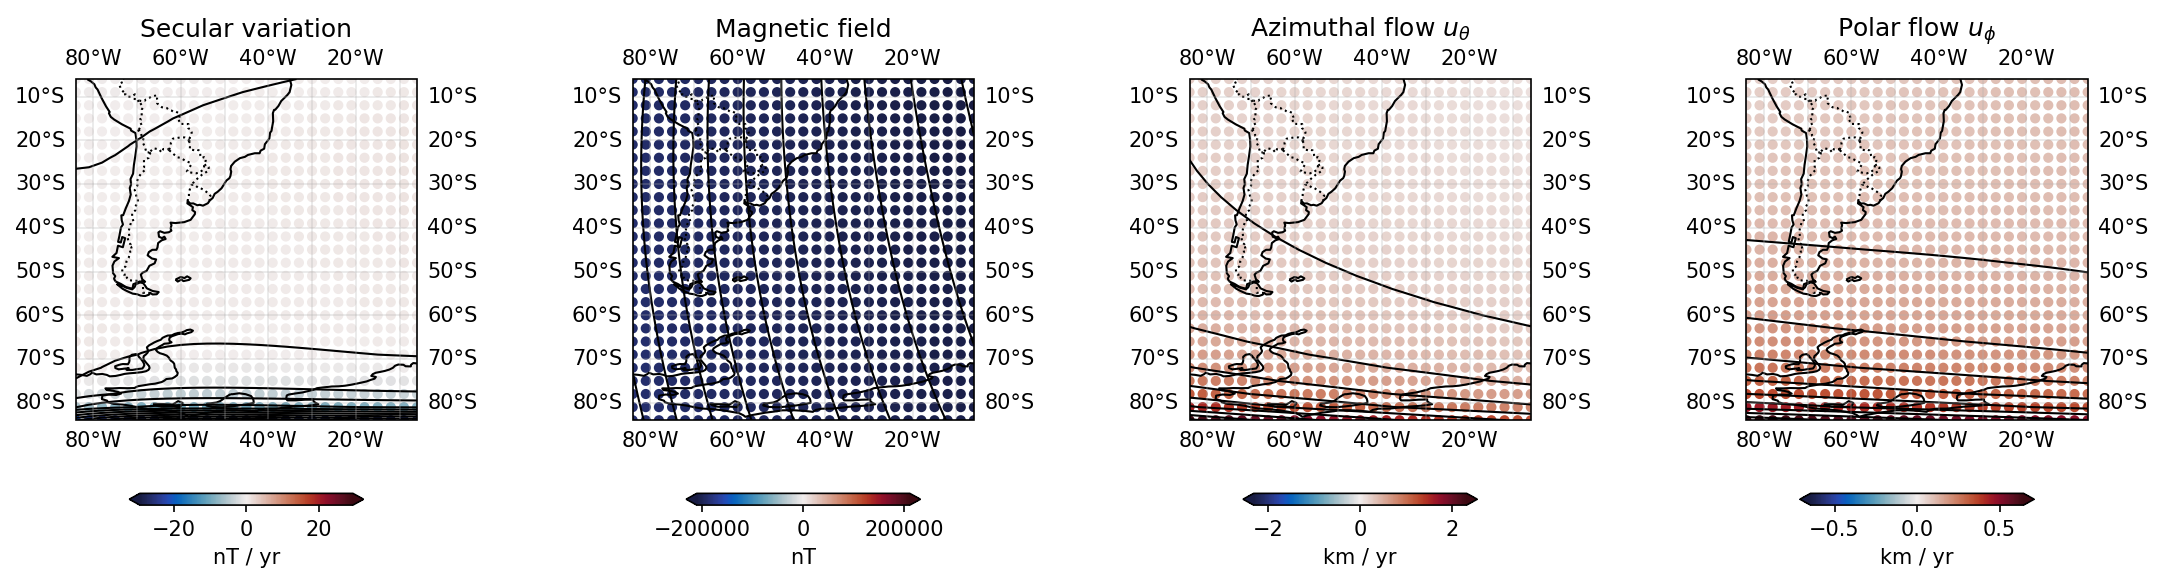

In [25]:
maps = ["dbrdt", "br", "uth", "uph"]

fig, axes = plt.subplots(1, len(maps), subplot_kw={'projection': ccrs.PlateCarree()}, sharex=True, sharey=True, figsize=(15, 4), dpi=150)

for n, map in enumerate(maps):
    pred = predictions[map]

    # Maximum value took by the observations
    vmax = numpy.max(numpy.abs(pred))

    # Arguments for the plot
    kwargs = {"cmap": cmocean.cm.balance, "vmin": -vmax, "vmax": vmax, "s": 15, "marker": "o"}

    cb = axes[n].scatter(long_grid, lat_grid, c=pred, **kwargs)

    axes[n].contour(long_grid, lat_grid, pred, colors=['black'], levels=10, linewidths=1, linestyles="solid")

    axes[n].coastlines(resolution='110m')
    axes[n].add_feature(cfeature.BORDERS, linestyle=':')
    axes[n].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
    axes[n].set_title(suptitles[map])

    cbar = plt.colorbar(cb, orientation="horizontal", shrink=0.5, extend="both")

    cbar.set_label(units[map])

plt.tight_layout()
fig.savefig(os.path.join(fig_dir, f"prediction.png"))

### 9) Losses

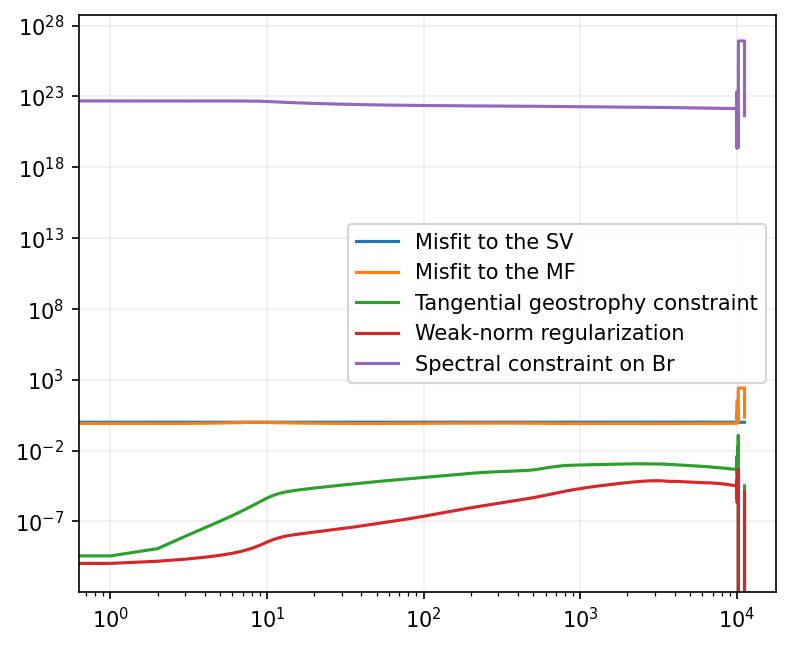

In [27]:
labels = {
    "misfit_dbrdt": "Misfit to the SV",
    "misfit_br": "Misfit to the MF",
    "tangential_geostrophy": "Tangential geostrophy constraint",
    "toroidal": "Toroidality constraint",
    "weak_norm": "Weak-norm regularization",
    "strong_norm": "Strong-norm regularization",
    "frozen_flux": "Frozen-flux condition",
    "spectral_br": "Spectral constraint on Br"
}

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=150)

for name in saved_losses:
    ax.loglog(saved_losses[name], label=labels[name])

ax.grid(alpha=0.2)
ax.legend()

fig.savefig(os.path.join(fig_dir, "losses.png"))

### 10) Diagnostics

In [28]:
name = "uth"

obs = observations[name][slice_thetas, slice_phis]
pred = predictions[name]
Δ = numpy.abs(obs - pred)

rmse = numpy.sqrt(numpy.mean(Δ**2))
re_max = 100 * Δ.mean() / numpy.abs(obs).max()

print(f"RMSE = {rmse:.2E} {units[name]}")
print(f"Relative error (% of max) = {re_max:.2E}")

print(f"{name}\t{rmse:.2E} {units[name]}\t{round(re_max, 2)} % of max.")

RMSE = 5.90E+00 km / yr
Relative error (% of max) = 2.41E+01
uth	5.90E+00 km / yr	24.11 % of max.


In [29]:
uθ_pred, uφ_pred = predictions["uth"], predictions["uph"]
uθ_obs, uφ_obs = observations["uth"][slice_thetas, slice_phis], observations["uph"][slice_thetas, slice_phis]

dθ = numpy.gradient(thetas).mean()
dφ = numpy.gradient(phis).mean()

sinθ = numpy.sin(thetas_grid[slice_thetas, slice_phis])

dΩ = sinθ * dθ * dφ

Corr_obs_obs = numpy.sum((uθ_obs**2 + uφ_obs**2) * dΩ)
Corr_pred_pred = numpy.sum((uθ_pred**2 + uφ_pred**2) * dΩ)
Corr_obs_pred = numpy.sum((uθ_obs * uθ_pred + uφ_obs * uφ_pred) * dΩ)

Corr = Corr_obs_pred / numpy.sqrt(Corr_obs_obs * Corr_pred_pred)

print(f"{round(Corr, 3)}")

0.061


In [30]:
# Computing the complexity on the observed field
uθ = predictions["uth"]
uφ = predictions["uph"]

θ = thetas[slice_thetas]
φ = phis[slice_phis]

sinθ = numpy.sin(thetas_grid[slice_thetas, slice_phis]).clip(1e-2, 1)
cosθ = numpy.cos(thetas_grid[slice_thetas, slice_phis])

dΩ = sinθ * dθ * dφ

duθdθ = numpy.gradient(uθ, θ, axis=0)
duθdφ = numpy.gradient(uθ, φ, axis=1)
duφdθ = numpy.gradient(uφ, θ, axis=0)
duφdφ = numpy.gradient(uφ, φ, axis=1)

d2uθdθ: torch.Tensor = numpy.gradient(duθdθ, θ, axis=0)
d2uθdφ: torch.Tensor = numpy.gradient(duθdφ, φ, axis=1)
d2uφdθ: torch.Tensor = numpy.gradient(duφdθ, θ, axis=0)
d2uφdφ: torch.Tensor = numpy.gradient(duφdφ, φ, axis=1)

Δuθ = (1 / (r**2 * sinθ)) * (cosθ * duθdθ + sinθ * d2uθdθ) + (1 / (r * sinθ)**2) * d2uθdφ
Δuφ = (1 / (r**2 * sinθ)) * (cosθ * duφdθ + sinθ * d2uφdθ) + (1 / (r * sinθ)**2) * d2uφdφ

area = numpy.sum(dΩ)

divh_uh= (1 / (r * sinθ)) * (duθdθ * sinθ + uθ * cosθ + duφdφ)

weak_norm = numpy.sum((uθ**2 + uφ**2) * dΩ) / area
strong_norm = numpy.sum((Δuθ**2 + Δuφ**2) * dΩ) / area
tangential_geostrophy = cosθ * divh_uh - uθ * sinθ / r
toroidality = divh_uh

# Misfit
dbrdt_obs = observations["dbrdt"][slice_thetas, slice_phis]
dbrdt_pred = predictions["dbrdt"]
L1 = ((dbrdt_obs - dbrdt_pred)**2).mean() / (dbrdt_obs**2).mean()

print(f"Correlation: {Corr:.2E}")
print(f"Weak norm: {weak_norm:.2E}")
print(f"Strong norm: {strong_norm:.2E}")
print("---")
print(f"Tangential geostrophy: {tangential_geostrophy.mean():.2E}")
print(f"Toroidality: {toroidality.mean():.2E}")
print("---")
print(f"Misfit: {L1:.2E}")

print(losses)

Correlation: 6.10E-02
Weak norm: 1.18E-01
Strong norm: 2.43E-13
---
Tangential geostrophy: 1.20E-05
Toroidality: -5.94E-05
---
Misfit: 1.00E+00
{'misfit_dbrdt': 1, 'misfit_br': 1, 'tangential_geostrophy': 10000.0, 'weak_norm': 0.0001, 'spectral_br': 1.0}


### Testing the filter

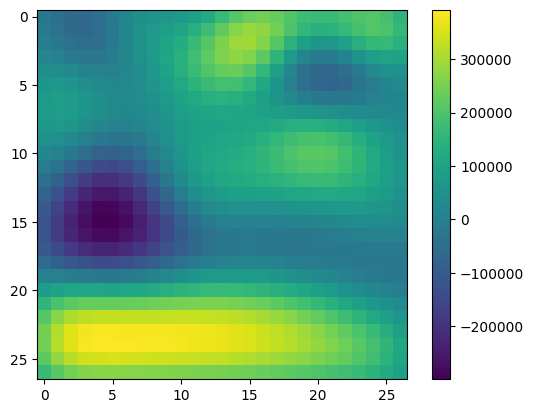

In [31]:

from scipy.ndimage import gaussian_filter

# Instead of MF[-1, ..., 1], take the same patch used for training:
br_patch = observations["br"][slice_thetas, slice_phis]       # shape e.g. (27, 27)
br = torch.tensor(br_patch.reshape(-1, 1), dtype=torch.float32, requires_grad=True)

br_from_torch = gaussian_filter_2d_torch(br, sigma=2).requires_grad_(True)

plt.imshow(br_from_torch.detach().numpy().reshape(br_patch.shape))
plt.colorbar()
